In [1]:
import pandas as pd
import numpy as np

In [2]:
high_schools = pd.read_csv('../data/full_highschool_data.csv')
high_schools.dropna(subset=['ACT'], inplace=True)

C:\Users\David\AppData\Local\Temp\ipykernel_19704\1127357357.py:1: DtypeWarning: Columns (804,805,1040,1041,1159,1160,1203) have mixed types. Specify dtype option on import or set low_memory=False.
  high_schools = pd.read_csv('../data/full_highschool_data.csv')


In [3]:
# sort columns by percentage NA
(high_schools.isna().sum()/high_schools.shape[0]).sort_values(ascending=False)

SCH_HBREPORTED_DIS_WH_F       1.0
SCH_DISCWODIS_MULTOOS_AM_M    1.0
SCH_DISCWODIS_MULTOOS_WH_F    1.0
SCH_DISCWODIS_MULTOOS_WH_M    1.0
SCH_DISCWODIS_MULTOOS_BL_F    1.0
                             ... 
TOT_DISCWODIS_EXPZT_F         0.0
TOT_DISCWODIS_EXPZT_M         0.0
SCH_DISCWODIS_EXPZT_TR_F      0.0
SCH_DISCWODIS_EXPZT_TR_M      0.0
ACT                           0.0
Length: 1397, dtype: float64

In [4]:
# drop columns with no data
high_schools = high_schools.dropna(axis=1, how='all')
high_schools.shape

(6918, 914)

In [5]:
# fill in values for missing indicators
high_schools['SCH_FIREARM_IND'].fillna(False, inplace=True)
high_schools['SCH_HOMICIDE_IND'].fillna(False, inplace=True)
high_schools['SCH_RET_G09_IND'].fillna(False, inplace=True)
high_schools['SCH_RET_G10_IND'].fillna(False, inplace=True)
high_schools['SCH_RET_G11_IND'].fillna(False, inplace=True)
high_schools['SCH_SSCLASSES_IND'].fillna(False, inplace=True)
high_schools['SCH_APSEL'].fillna(False, inplace=True)
high_schools['SCH_APMATHENR_IND'].fillna(False, inplace=True)
high_schools['SCH_APSCIENR_IND'].fillna(False, inplace=True)
high_schools['SCH_APOTHENR_IND'].fillna(False, inplace=True)

In [6]:
# fix enrolment for special cases
high_schools[~high_schools['SCH_APENR_IND']].filter(regex=r'.*_AP.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_CORPINSTANCES_IND']].filter(regex=r'.*_(DISCWO?DIS|CORPINSTANCES).*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_CREDITRECOVERY_IND']].filter(regex=r'.*_CREDITRECOVERY.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_DUAL_IND']].filter(regex=r'.*_DUAL.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_GT_IND']].filter(regex=r'.*_GTENR.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_IBENR_IND']].filter(regex=r'.*_IB.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_SSCLASSES_IND']].filter(regex=r'.*_SSCLASSES.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_SSATHLETICS_IND']].filter(regex=r'.*_SS(SPORTS|TEAMS|PART).*',axis=1).fillna(0, inplace=True)

In [7]:
# drop columns with more than 60% na vals
high_schools = high_schools.dropna(axis=1, thresh=int(high_schools.shape[0]*(1-.6)))
high_schools.shape

(6918, 837)

In [8]:
# mark state and district name as a categorical variable
from sklearn.preprocessing import OrdinalEncoder
high_schools['LEA_STATE_NAME'] = OrdinalEncoder().fit_transform(high_schools['LEA_STATE_NAME'].to_numpy().reshape(-1,1))
high_schools['LEA_NAME'] = OrdinalEncoder().fit_transform(high_schools['LEA_NAME'].to_numpy().reshape(-1,1))

In [9]:
g = high_schools.columns.to_series().groupby(high_schools.dtypes).groups
high_schools = high_schools.loc[:,~high_schools.columns.isin({k.name: v for k, v in g.items()}['object'])]
X = high_schools.iloc[:,:-1]
X.drop(['LEAID','LEA_NAME','SCHID','COMBOKEY'], axis=1, inplace=True)
y = high_schools['ACT']

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
from sklearn.impute import KNNImputer
X_np = KNNImputer().fit_transform(X)
X = pd.DataFrame(X_np, columns=high_schools.drop(['LEAID','LEA_NAME','SCHID','COMBOKEY'], axis=1).iloc[:,:-1].columns)

In [12]:
# replace missing data with either mean or median depending on skewness
# from scipy.stats import skew
#
# for i, col in enumerate(high_schools.columns):
#     if high_schools[col].dtype == object:
#         continue
#     sk = skew(high_schools[col], nan_policy='omit')
#     if abs(sk) > 1:
#         high_schools[col].fillna(high_schools[col].median(), inplace=True)
#     else:
#         high_schools[col].fillna(high_schools[col].mean(), inplace=True)

In [13]:
X.isna().sum()

LEA_STATE_NAME                0
SCH_MATHCLASSES_ADVM          0
SCH_MATHCERT_ADVM             0
SCH_MATHENR_ADVM_HI_M         0
SCH_MATHENR_ADVM_HI_F         0
                             ..
TOT_DISCWDIS_TFRALT_IDEA_F    0
SCH_DISCWDIS_TFRALT_LEP_M     0
SCH_DISCWDIS_TFRALT_LEP_F     0
SCH_DISCWDIS_TFRALT_504_M     0
SCH_DISCWDIS_TFRALT_504_F     0
Length: 830, dtype: int64

In [14]:
X.to_csv('../data/processed_data.csv')

In [15]:
X_all_tot = X.filter(regex=r'^TOT')

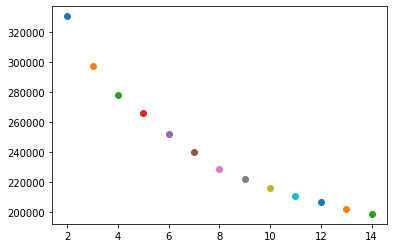

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

for k in range(2,15):
    km = KMeans(n_clusters=k).fit(X_all_tot)
    # score = silhouette_score(X, km.labels_)
    plt.scatter(k, km.inertia_)

In [17]:
km = KMeans(n_clusters=5).fit(X_all_tot)

In [18]:
X[km.labels_==0]['LEA_STATE_NAME'].value_counts(),X[km.labels_==1]['LEA_STATE_NAME'].value_counts(),X[km.labels_==2]['LEA_STATE_NAME'].value_counts(),X[km.labels_==3]['LEA_STATE_NAME'].value_counts(),X[km.labels_==4]['LEA_STATE_NAME'].value_counts()

( 0.885209    911
 -0.789297    428
 -0.370670    390
  1.303836    385
  0.047956    348
  0.675896    237
 -1.207923    234
 -1.835863    232
 -0.579983    210
  0.257269    176
 -0.998610    142
 -1.417236    137
  0.466583    125
  1.094522    101
 -0.161357     80
 -1.626549     73
  1.513149     60
 Name: LEA_STATE_NAME, dtype: int64,
  0.885209    296
  1.303836    265
 -0.370670    169
  0.257269    160
 -1.417236    155
 -1.626549    149
 -0.789297    108
 -1.835863     99
  0.675896     89
  0.466583     75
 -1.207923     62
 -0.998610     56
  1.094522     54
  0.047956     39
 -0.579983     22
  1.513149     10
 -0.161357      8
 Name: LEA_STATE_NAME, dtype: int64,
  0.885209    320
 -1.626549     62
 -1.417236     47
  0.257269     27
 -1.835863     24
 -0.370670     22
  1.094522     19
 -0.998610     17
  0.466583     14
  0.047956     14
  1.303836     13
 -0.579983      6
  0.675896      6
 -0.789297      4
 -1.207923      1
 Name: LEA_STATE_NAME, dtype: int64,
  0.885

In [19]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_all_tot,y)
score = lr.score(X_all_tot,y)
score

0.31525156138284405

In [20]:
col_groups= pd.read_excel('../data/2017-18-crdc-data/Documentation/2017-18 CRDC File Structure.xlsx', sheet_name=None)
col_groups.pop('LEA Characteristics')
col_groups.pop('High School Equivalency (GED)')
col_groups.pop('Distance Education')

,Column Finder,Field Name,Field Description
0,A,LEA_STATE,State Abbreviation
1,B,LEA_STATE_NAME,State Name
2,C,LEAID,7 Digit LEAID District Identification Code
3,D,LEA_NAME,District Name
4,E,LEA_ADDRESS,District Address
5,F,LEA_CITY,District City
6,G,LEA_ZIP,District Zip code
7,H,CJJ,"Juvenile Justice Facility (LEA): ""Yes"" indicat..."
8,I,LEA_DISTED_IND,Distance Education Enrollment Indicator (LEA):...
9,J,LEA_DISTEDENR_HI_M,Distance Education Enrollment (LEA): Hispanic...


In [21]:
from sklearn.decomposition import PCA
X_components = np.empty((len(col_groups),X.shape[1]))
means = []
for i, (name, group) in enumerate(col_groups.items()):
    # full_component = np.empty(X.shape[1])
    subset = np.intersect1d(group['Field Name'].iloc[8:], X.columns)
    if len(subset) == 0:
        continue
    pca = PCA(1).fit(X[subset])
    component = pca.components_
    means+=list(pca.mean_)
    X_components[i, list(map(lambda x: X.columns.get_loc(x), subset))] = component

In [22]:
# manually transform principle components
X_reduced = np.dot(X-X.mean(),X_components.T)[:,1:]

i=2, score=0.52803604876373
i=3, score=0.4255924166862205
i=4, score=0.33484176441082175
i=5, score=0.3355849276667682
i=6, score=0.3362906617742173
i=7, score=0.3408377492671075
i=8, score=0.32972057006406746
i=9, score=0.3353080174673749
i=10, score=0.2725293400912376
i=11, score=0.2582846612522904
i=12, score=0.25591638766656816
i=13, score=0.25385987355588907
i=14, score=0.20481831861216615
i=15, score=0.22953237043751296
i=16, score=0.23113364926035218
i=17, score=0.22601754473906002
i=18, score=0.22422488807387506
i=19, score=0.2322623811358301
i=20, score=0.1590983522980289
i=21, score=0.15047812822173623
i=22, score=0.1575460524996921
i=23, score=0.1862894996407869
i=24, score=0.1472751546440649
i=25, score=0.15897332553266125
i=26, score=0.1514962550968069
i=27, score=0.14117045572463383
i=28, score=0.14790482730952131
i=29, score=0.10215127825385173
i=30, score=0.17363014314715083
i=31, score=0.16323971549052924
i=32, score=0.1458539380074134
i=33, score=0.16546376866411935
i

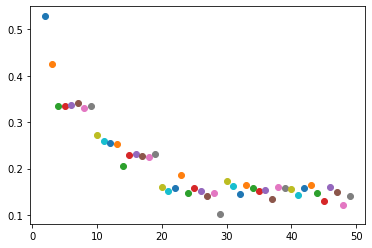

In [23]:
from sklearn.metrics import silhouette_score
wcss = []

for i in range(2,50):
    km = KMeans(i, random_state=0)
    km.fit(X_reduced)
    wcss.append(km.inertia_)
    score = silhouette_score(X_reduced, km.labels_, metric='euclidean')
    plt.scatter(i, score)
    print(f'{i=}, {score=}')

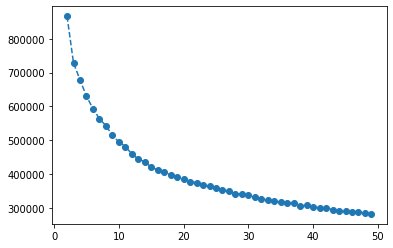

In [24]:
plt.plot(range(2,50), wcss, marker='o', linestyle='--')
plt.show()

In [25]:
for i in set(km.labels_):
    subset = high_schools[km.labels_==i]
    print(f'Cluster {i}, length = {subset.shape[0]}')
    # print(subset['LEA_STATE_NAME'].value_counts())

Cluster 0, length = 162
Cluster 1, length = 99
Cluster 2, length = 150
Cluster 3, length = 1572
Cluster 4, length = 87
Cluster 5, length = 164
Cluster 6, length = 6
Cluster 7, length = 17
Cluster 8, length = 1
Cluster 9, length = 31
Cluster 10, length = 30
Cluster 11, length = 1068
Cluster 12, length = 28
Cluster 13, length = 83
Cluster 14, length = 119
Cluster 15, length = 136
Cluster 16, length = 90
Cluster 17, length = 53
Cluster 18, length = 14
Cluster 19, length = 665
Cluster 20, length = 72
Cluster 21, length = 56
Cluster 22, length = 14
Cluster 23, length = 23
Cluster 24, length = 39
Cluster 25, length = 35
Cluster 26, length = 38
Cluster 27, length = 239
Cluster 28, length = 62
Cluster 29, length = 1
Cluster 30, length = 144
Cluster 31, length = 45
Cluster 32, length = 485
Cluster 33, length = 3
Cluster 34, length = 4
Cluster 35, length = 13
Cluster 36, length = 14
Cluster 37, length = 8
Cluster 38, length = 98
Cluster 39, length = 52
Cluster 40, length = 143
Cluster 41, length

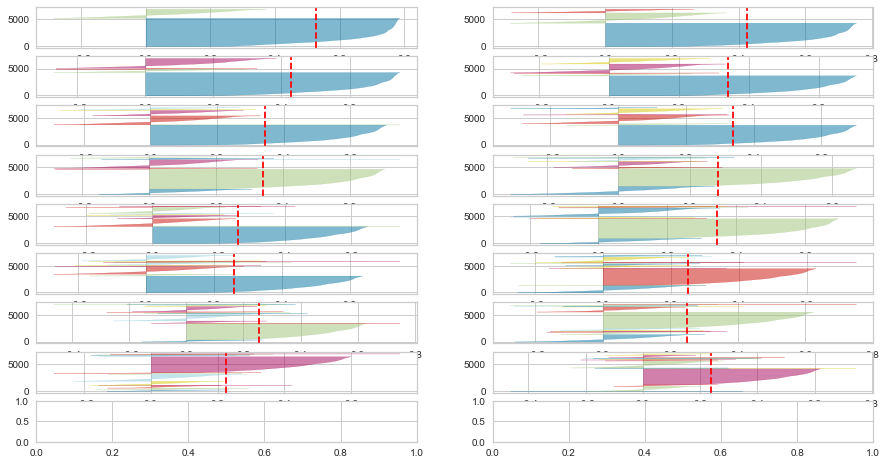

In [26]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(9,2, figsize=(15,8))
for i in range(2,18):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_reduced)

(0.0, 10.0)

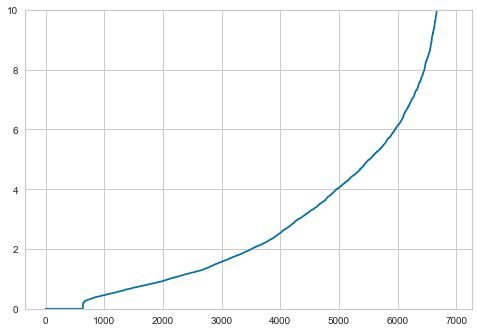

In [27]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_reduced)
distances, indices = nbrs.kneighbors(X_reduced)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.ylim(0, 10)

i=2, score=0.462923987457924
i=3, score=0.4130391253124227
i=4, score=0.4166164993969914
i=5, score=0.4171882225787086
i=6, score=0.4177798186590542
i=7, score=0.21893029614269563
i=8, score=0.22348651552563004
i=9, score=0.22636104798123338
i=10, score=0.22498955985427338
i=11, score=0.2265316118627857
i=12, score=0.22504221033413183
i=13, score=0.22284163342474275
i=14, score=0.21814685760245342
i=15, score=0.22120789740321392
i=16, score=0.22167434044449855
i=17, score=0.2228298154188138
i=18, score=0.22949353308762527
i=19, score=0.2303826398899271
i=20, score=0.23057212192808493
i=21, score=0.23135174740550193
i=22, score=0.22790985041085293
i=23, score=0.2293481357924444
i=24, score=0.23030447277168647
i=25, score=0.23103135433896405
i=26, score=0.23125594327258225
i=27, score=0.23164543697868623
i=28, score=0.23265685526551616
i=29, score=0.12573762482184914
i=30, score=0.1199230523524397
i=31, score=0.12271427912758882
i=32, score=0.12111671557554299
i=33, score=0.1216176952309

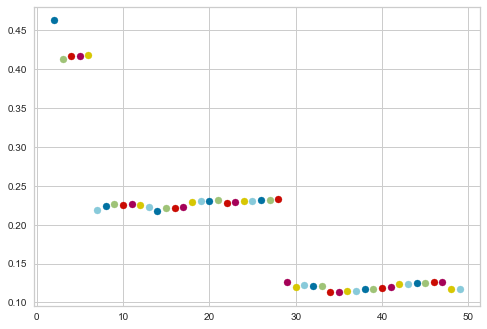

In [28]:
from sklearn.cluster import AgglomerativeClustering
wcss = []

for i in range(2,50):
    ag = AgglomerativeClustering(i)
    ag.fit(X_reduced)
    score = silhouette_score(X_reduced, ag.labels_, metric='euclidean')
    plt.scatter(i, score)
    print(f'{i=}, {score=}')

ep=1, score=-0.3609784310827115
ep=2, score=-0.16921332668215996
ep=3, score=-0.10130508475010029
ep=4, score=-0.06793589271770904
ep=5, score=0.13410062082761573
ep=6, score=0.10518993509341498
ep=7, score=0.15264389462111608
ep=8, score=0.33146684369228413
ep=9, score=0.43790876758878666
ep=10, score=0.5104118079509422
ep=11, score=0.543635625484037
ep=12, score=0.4935505391774629
ep=13, score=0.5106020391349629
ep=14, score=0.6345742578957106
ep=15, score=0.6338042551198473
ep=16, score=0.6319295204079577
ep=17, score=0.6267831056227899
ep=18, score=0.626233686170011
ep=19, score=0.7328731410092131


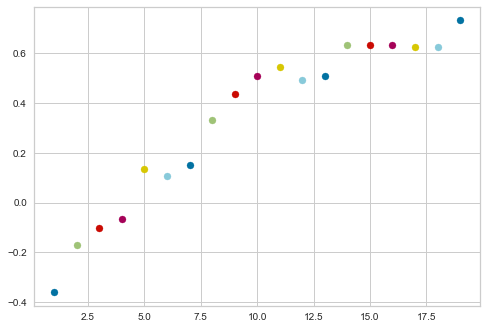

In [29]:
from sklearn.cluster import DBSCAN
for ep in range(1,20):
    db = DBSCAN(ep).fit(X_reduced)
    score = silhouette_score(X_reduced, db.labels_, metric='euclidean')
    plt.scatter(ep,score)
    print(f'{ep=}, {score=}')

In [30]:
# db = DBSCAN(11).fit(X_reduced)
np.unique(db.labels_, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([  36, 6874,    8], dtype=int64))

n=2, score=0.44278851915121953
n=3, score=0.3933504506043472
n=4, score=0.3802471842322601
n=5, score=0.3817037436970746
n=6, score=0.38229561107960097
n=7, score=0.3840953037272728
n=8, score=0.38781930382039653
n=9, score=0.3888310684594304
n=10, score=0.20134408428777614
n=11, score=0.1997374529063367
n=12, score=0.19312790463760296
n=13, score=0.19635538445940037
n=14, score=0.19712599797479252
n=15, score=0.1985142061860823
n=16, score=0.1976379486500895
n=17, score=0.1995192101314152
n=18, score=0.20675839339211166
n=19, score=0.2073710787839293


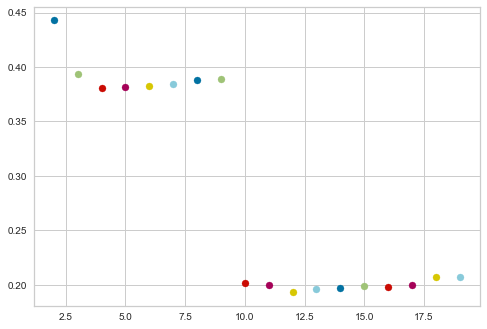

In [31]:
from sklearn.cluster import Birch

for n in range(2,20):
    br = Birch(n_clusters=n).fit(X_reduced)
    score = silhouette_score(X_reduced, br.labels_, metric='euclidean')
    plt.scatter(n,score)
    print(f'{n=}, {score=}')

In [69]:
br = Birch(n_clusters=9).fit(X_reduced)
np.unique(br.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([4322, 1438,  225,  140,  679,    1,   86,   17,   10], dtype=int64))

<BarContainer object of 9 artists>

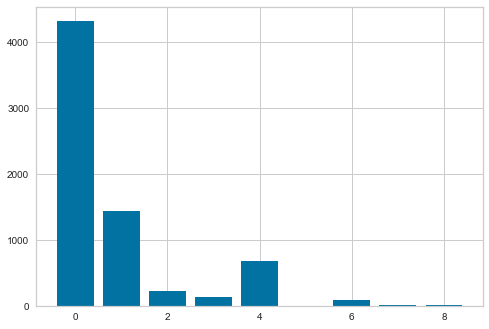

In [70]:
plt.bar(*np.unique(br.labels_, return_counts=True))

In [85]:
rows = []
for clust in np.unique(br.labels_):
    for col in range(len(X_reduced[0])):
        rows.append([clust, col, X_reduced[br.labels_==clust,col].mean(), X_reduced[br.labels_==clust,col].std()])
# X_reduced[br.labels_==2]

rows2 = []
for col in range(len(X_reduced[0])):
        rows2.append([col, X_reduced[:,col].mean(), X_reduced[:,col].std()])

In [86]:
local_center_spread = pd.DataFrame(rows, columns=['clust','col','mean','std'])
global_center_spread = pd.DataFrame(rows2, columns=['col','mean','std'])

In [104]:
# abs((local_center_spread[local_center_spread['clust']==0][['mean','std']]).to_numpy()-global_center_spread[['mean','std']].to_numpy()) > 2
# abs((local_center_spread[local_center_spread['clust']==1][['mean','std']]).to_numpy()-global_center_spread[['mean','std']].to_numpy()) > 2
# abs((local_center_spread[local_center_spread['clust']==2][['mean','std']]).to_numpy()-global_center_spread[['mean','std']].to_numpy()) > 2
abs((local_center_spread[local_center_spread['clust']==3][['mean','std']]).to_numpy()-global_center_spread[['mean','std']].to_numpy()) > 2
# abs((local_center_spread[local_center_spread['clust']==4][['mean','std']]).to_numpy()-global_center_spread[['mean','std']].to_numpy()) > 2
# abs((local_center_spread[local_center_spread['clust']==5][['mean','std']]).to_numpy()-global_center_spread[['mean','std']].to_numpy()) > 2

array([[False,  True],
       [False,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [ True,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [ True,  True]])

In [34]:
X_red_df[br.labels_==7]

NameError: name 'X_red_df' is not defined

In [61]:
col_names = ['method','score','mse','Advanced Mathematics','Advanced Placement','Algebra I','Algebra II','Biology','Calculus','Chemistry','Corporal Punishment','Credit Recovery','Dual Enrolment','Enrolment','Expulsions','Geometry','Gifted and Talented','Harassment and Bullying','International Baccalaureate','Offenses','Physics','Referrals and Arrests','Restraint and Seclusion','Retention','SAT and ACT','School Characteristics','School Expenditures','School Support','Single-sex Athletics','Single-sex Classes','Suspensions','Transfers']
rows = []

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
X_trainr, X_testr, y_trainr, y_testr = train_test_split(X_reduced, y)
lr = LinearRegression().fit(X_trainr,y_trainr)
score = lr.score(X_testr, y_testr)
mse = mean_squared_error(y_testr, lr.predict(X_testr))
rows.append(['LinearRegression',score,mse,*lr.coef_])
f'R^2 = {(cross_val_score(lr,X_testr,y_testr,cv=5, scoring="r2").mean())}'

'R^2 = 0.26498248828829407'

In [63]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_trainr, y_trainr)
score = ridge.score(X_testr, y_testr)
mse = mean_squared_error(y_testr, ridge.predict(X_testr))
rows.append(['Ridge',score,mse,*ridge.coef_])
f'R^2 = {(cross_val_score(ridge,X_testr,y_testr,cv=5, scoring="r2").mean())}'

'R^2 = 0.26477251977618305'

In [64]:
from sklearn.linear_model import Lasso
lasso = Lasso(random_state=0).fit(X_trainr, y_trainr)
score = lasso.score(X_testr, y_testr)
mse = mean_squared_error(y_testr, lasso.predict(X_testr))
rows.append(['Lasso',score,mse,*lasso.coef_])
f'R^2 = {(cross_val_score(lasso,X_testr,y_testr,cv=5, scoring="r2").mean())}'

'R^2 = 0.16275568121268616'

In [65]:
from sklearn.svm import SVR
svr = SVR(kernel='linear').fit(X_trainr, y_trainr)
score = svr.score(X_testr, y_testr)
mse = mean_squared_error(y_testr, svr.predict(X_testr))
rows.append(['SVR',score,mse,*svr.coef_[0]])
f'R^2 = {(cross_val_score(svr,X_testr,y_testr,cv=5, scoring="r2").mean())}'

'R^2 = 0.25440696560223364'

In [66]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor().fit(X_trainr, y_trainr)
score = dtr.score(X_testr, y_testr)
mse = mean_squared_error(y_testr, dtr.predict(X_testr))
rows.append(['DTR',score,mse,*([np.nan]*29)])
f'R^2 = {(cross_val_score(dtr,X_testr,y_testr,cv=5, scoring="r2").mean())}'

'R^2 = -0.2574291263062669'

In [67]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(5).fit(X_trainr, y_trainr)
score = knr.score(X_testr, y_testr)
mse = mean_squared_error(y_testr, knr.predict(X_testr))
rows.append(['KNR',score,mse,*([np.nan]*29)])
f'R^2 = {(cross_val_score(knr,X_testr,y_testr,cv=5, scoring="r2").mean())}'

'R^2 = 0.2790853411812672'

In [68]:
component_per_sheet_res = pd.DataFrame(rows, columns=col_names)
component_per_sheet_res

,method,score,mse,Advanced Mathematics,Advanced Placement,Algebra I,Algebra II,Biology,Calculus,Chemistry,...,Restraint and Seclusion,Retention,SAT and ACT,School Characteristics,School Expenditures,School Support,Single-sex Athletics,Single-sex Classes,Suspensions,Transfers
0,LinearRegression,0.271452,5.231018,0.159481,-0.001205,-0.067115,0.035656,0.188866,0.084975,0.079115,...,1.734723e-17,-0.069899,-0.041341,-0.097162,0.006777,0.150248,0.229809,-0.220431,0.0,0.018868
1,Ridge,0.271451,5.231024,0.159484,-0.001207,-0.067102,0.035644,0.188855,0.084966,0.079098,...,0.000000e+00,-0.069903,-0.041345,-0.097154,0.006780,0.150220,0.229798,-0.220375,0.0,0.018864
2,Lasso,0.157312,6.050546,0.152686,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,-0.068904,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.0,-0.000000
3,SVR,0.259082,5.319834,0.149961,-0.004310,-0.052735,-0.004653,0.187461,0.119329,0.030537,...,0.000000e+00,-0.160731,-0.062709,-0.117114,0.010343,0.116531,0.263933,-0.179212,0.0,0.024481
4,DTR,-0.166168,8.373151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,KNR,0.315958,4.911461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
rows = []
X_traint, X_testt, y_traint, y_testt = train_test_split(X_all_tot, y)
lr = LinearRegression().fit(X_traint,y_traint)
score = lr.score(X_testt, y_testt)
rows.append(['LinearRegression',score,*lr.coef_])
f'R^2 = {score}'

In [ ]:
ridge = Ridge().fit(X_traint, y_traint)
score = ridge.score(X_testt, y_testt)
rows.append(['Ridge',score,*ridge.coef_])
f'R^2 = {score}'

In [ ]:
lasso = Lasso(random_state=0).fit(X_traint, y_traint)
score = lasso.score(X_testt, y_testt)
rows.append(['Lasso',score,*lasso.coef_])
f'R^2 = {score}'

In [ ]:
svr = SVR(kernel='linear').fit(X_traint, y_traint)
score = svr.score(X_testt, y_testt)
rows.append(['SVR',score,*svr.coef_[0]])
f'R^2 = {score}'

In [ ]:
dtr = DecisionTreeRegressor().fit(X_traint, y_traint)
score = dtr.score(X_testt, y_testt)
rows.append(['DTR',score,*([np.nan]*29)])
f'R^2 = {score}'

In [ ]:
knr = KNeighborsRegressor(20).fit(X_traint, y_traint)
score = knr.score(X_testt, y_testt)
rows.append(['KNR',score,*([np.nan]*29)])
f'R^2 = {score}'

In [ ]:
all_tot_res = pd.DataFrame(rows, columns=['method','score',*X_all_tot.columns])
all_tot_res